In [1]:
# the packages that I used making when I solved these problems
# you might not have to use all of them 
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.stats as st
import xarray as xr
from itertools import product
import pandas as pd

# Lab 1.1

## The Central Limit Theorem: 
1. generate M variables that are the sum of N randomly drawn uniform variables and plot their distribution. Choose N and M each to be [10,100,1000]. 
2. Compare the distributions that you are computing to what the theoretical distribution should be.

Hint: For a uniform distribution between $(x_0, x_1)$ the mean is $0.5(x_0+x_1)$ and the variance is $(x_0,x_1)^2/12$. What will the mean and variance be of the sum of independent uniform variables?

Hint: you should think about what the normalization here is. For the theoretical distribution you are plotting you will have $\int P(x) dx = 1$. Is that true for the distribution that you are sampling from the data?

Note: efficient algorithms for sampling uniform variables were invented before algorithms for sampling Gaussian variables, so this algorithm with m=12 used to be one of the main choices for sampling Gaussian variables.

## Calculating statistics from data 
   1. open the 2m temperature data in the netcdf files in data/cities. For each city calculate the monthly mean and standard deviation of the 2m temperature. 

Hint: theres a few ways to do this: 
- simple: write a loop over the data arrays and select each month
- intermediate: load the data into a numpy array and use np.reshape to turn an array from [time] to [mon,year] and then use array operations.
- advanced: add a new monthly index and use the xarray group-by combine feature.

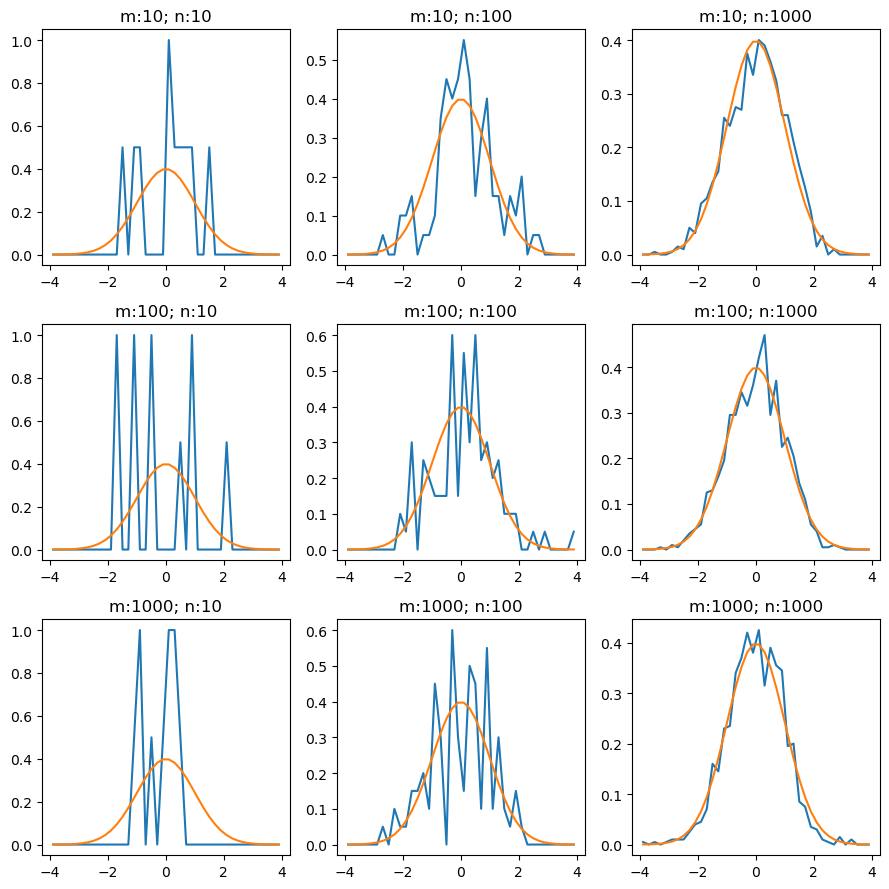

In [2]:
def gauss(x,a,b):
    return 1/np.sqrt(2*np.pi*b**2)*np.exp( -0.5*(x-a)**2/b**2)

nl=[10,100,1000]

edges=np.linspace(-4,4,41)
centers=(edges[1:]+edges[:-1])*0.5
d=edges[1]-edges[0]

fig,axs=plt.subplots(3,3,figsize=(9,9))
for (i,m),(j,n) in product(enumerate(nl),enumerate(nl)):
    S=(np.random.rand(m,n).sum(axis=0)-0.5*m)/np.sqrt(m**2/12)*np.sqrt(m)
    h,e=np.histogram(S,bins=edges)
    axs[i,j].plot(centers,h/(h.sum()*d))
    axs[i,j].plot(centers,gauss(centers,0,1))
    axs[i,j].set_title(f'm:{m}; n:{n}')

fig.tight_layout()

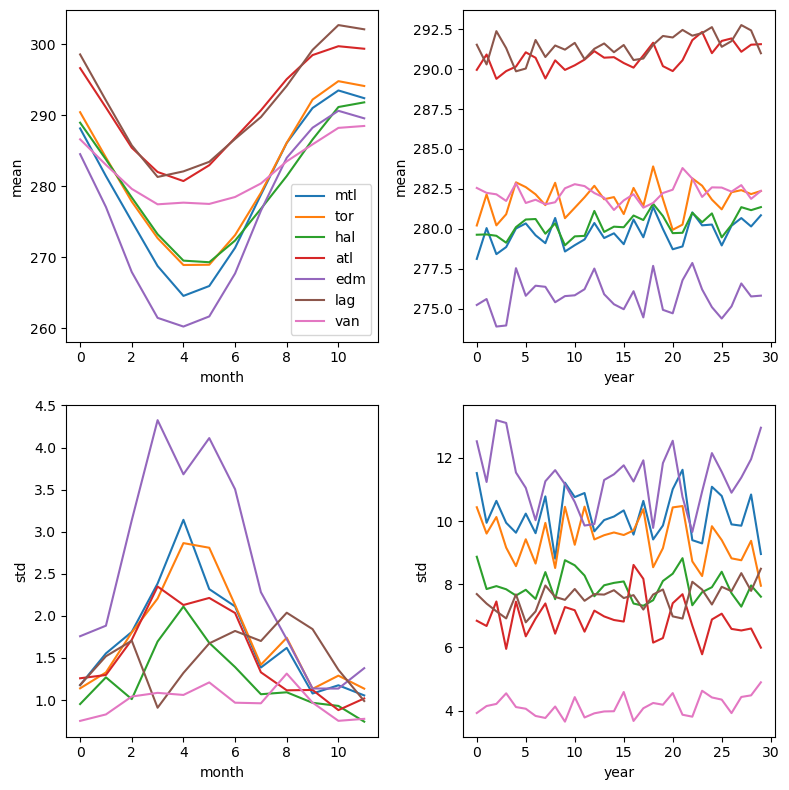

In [3]:
cities=['mtl','tor','hal','atl','edm','lag','van']
nc=len(cities)
ny=30
nm=12
tdata=np.zeros([nc,ny,nm])
for i,c in enumerate(cities):
    ds=xr.open_dataset(f'~/code/Upload_StatsCourse/data/cities/era5_t2m_{c}.nc')
    t=np.reshape(ds.t2m.data,[ny,nm])
    tdata[i,:,:]=t
    ds.close()

funcs=[np.mean,np.std]
avgs=[-2,-1]
xlabel=['month','year']
ylabel=['mean','std']
fig,axs=plt.subplots(2,2,figsize=(8,8))
for i,func in enumerate(funcs):
    for j,avg in enumerate(avgs):
        axs[i,j].plot(func(tdata,axis=avg).T,label=cities)
        axs[i,j].set_xlabel(xlabel[j])
        axs[i,j].set_ylabel(ylabel[i])
        if i==0 and j==0:
            axs[i,j].legend()
fig.tight_layout()

# Lab 1.2 

## Correlation and Independence 
1. Load the data in the aptly named FakeData.nc 
2. Compute the covariance and correlation coeffecient between y1,y2,y3 and x. 
3. For each y decide if the data is uncorrelated and/or independent of the variable x. Why or why not?
   
Hint: you might want to look at plots of the variables.
   
## Calculating second order statistics
1. Open the 2m temperature data in the netcdf files in data/cities. 
2. For each pair of cities calculate the annual mean covariance and correlation and display it
3. For each pair of cities calculate the monthly mean covariance and correlation and display it 
4. What is the difference between the covariance and correlation?
   
Hint: you should reuse your code from the previous lab!
   
Hint: there are many different ways to display this, one way is to plot the correlation matrix using plt.pcolor.

<xarray.Dataset>
Dimensions:  (x: 1000)
Coordinates:
  * x        (x) float64 -0.2813 -0.2818 -0.1791 ... -1.323 0.1702 -0.2059
Data variables:
    y1       (x) float64 ...
    y2       (x) float64 ...
    y3       (x) float64 ...


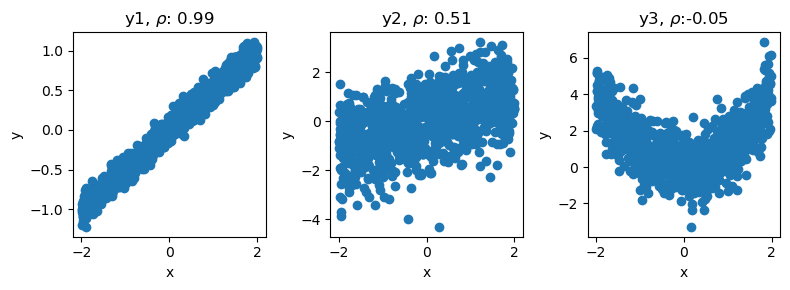

In [4]:
ds=xr.open_dataset('~/code/Upload_StatsCourse/data/FakeData.nc')
print(ds)
x=ds.x
yl=[ds.y1,ds.y2,ds.y3]

fig,axs=plt.subplots(1,3,figsize=(8,3))

for i,y in enumerate(yl):
    sx=x.std()
    sy=y.std()
    cxy=((x-x.mean())*(y-y.mean())).mean()
    rho=cxy/(sx*sy)
    rhos='% 0.2f' % rho.data
    axs[i].plot(ds.x,y,'o')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    axs[i].set_title(f'y{i+1}, $\\rho$:{rhos}')
    
fig.tight_layout()

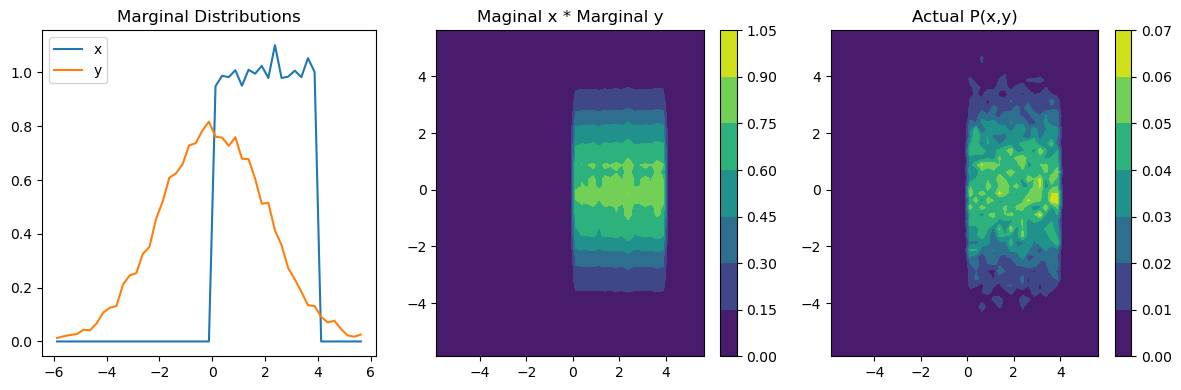

In [105]:
H,bx,by=np.histogram2d(4*np.random.rand(10000),2*np.random.randn(10000),
                       density=True,bins=[np.arange(-6,6,0.25),np.arange(-6,6,0.25)])

byc=.5*(by[1:]+by[:-1])
bxc=.5*(bx[1:]+bx[:-1])

Mx=np.sum(H,axis=1)
My=np.sum(H,axis=0)

plt.figure(0,figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(bxc,Mx,label='x')
plt.plot(byc,My,label='y')
plt.legend()
plt.title('Marginal Distributions')

plt.subplot(1,3,2)
plt.contourf(bxc,byc,Mx[np.newaxis,:]*My[:,np.newaxis])
plt.colorbar()
plt.title('Maginal x * Marginal y')

plt.subplot(1,3,3)
plt.contourf(bxc,byc,H.T)
plt.colorbar()
plt.title('Actual P(x,y)')

plt.tight_layout()


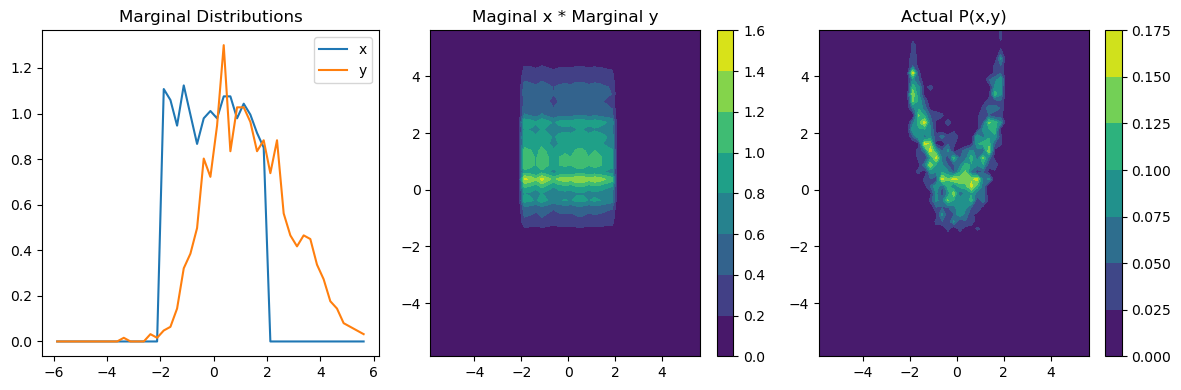

In [99]:
H,bx,by=np.histogram2d(ds.x,ds.y3,density=True,bins=[np.arange(-6,6,0.25),np.arange(-6,6,0.25)])

byc=.5*(by[1:]+by[:-1])
bxc=.5*(bx[1:]+bx[:-1])

Mx=np.sum(H,axis=1)
My=np.sum(H,axis=0)

plt.figure(0,figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(bxc,Mx,label='x')
plt.plot(byc,My,label='y')
plt.legend()
plt.title('Marginal Distributions')

plt.subplot(1,3,2)
plt.contourf(bxc,byc,Mx[np.newaxis,:]*My[:,np.newaxis])
plt.colorbar()
plt.title('Maginal x * Marginal y')

plt.subplot(1,3,3)
plt.contourf(bxc,byc,H.T)
plt.colorbar()
plt.title('Actual P(x,y)')

plt.tight_layout()


In [5]:
tdata_m_anom=tdata-tdata.mean(axis=1)[:,np.newaxis,:]
cov_mon=np.zeros([nc,nc,nm])
std_mon=np.zeros([nc,nm])
std_prod_mon=np.zeros([nc,nc,nm])

# do the calculations using 
# Cov_ij = mean(x_i'*x_j')
# Corr_ij = Cov_ij/(s_i*s_j)
# still have to loop over months though 
for m in range(0,12):
    cov_mon[:,:,m]=np.dot(tdata_m_anom[:,:,m],tdata_m_anom[:,:,m].T)/n
    std_mon[:,m]=np.sqrt(np.diag(cov_mon[:,:,m]))
    std_prod_mon[:,:,m]=np.dot(std_mon[:,m][:,np.newaxis],std_mon[:,m][:,np.newaxis].T)

cor_mon=cov_mon/std_prod_mon

/tmp/ipykernel_16106/434885909.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_16106/434885909.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


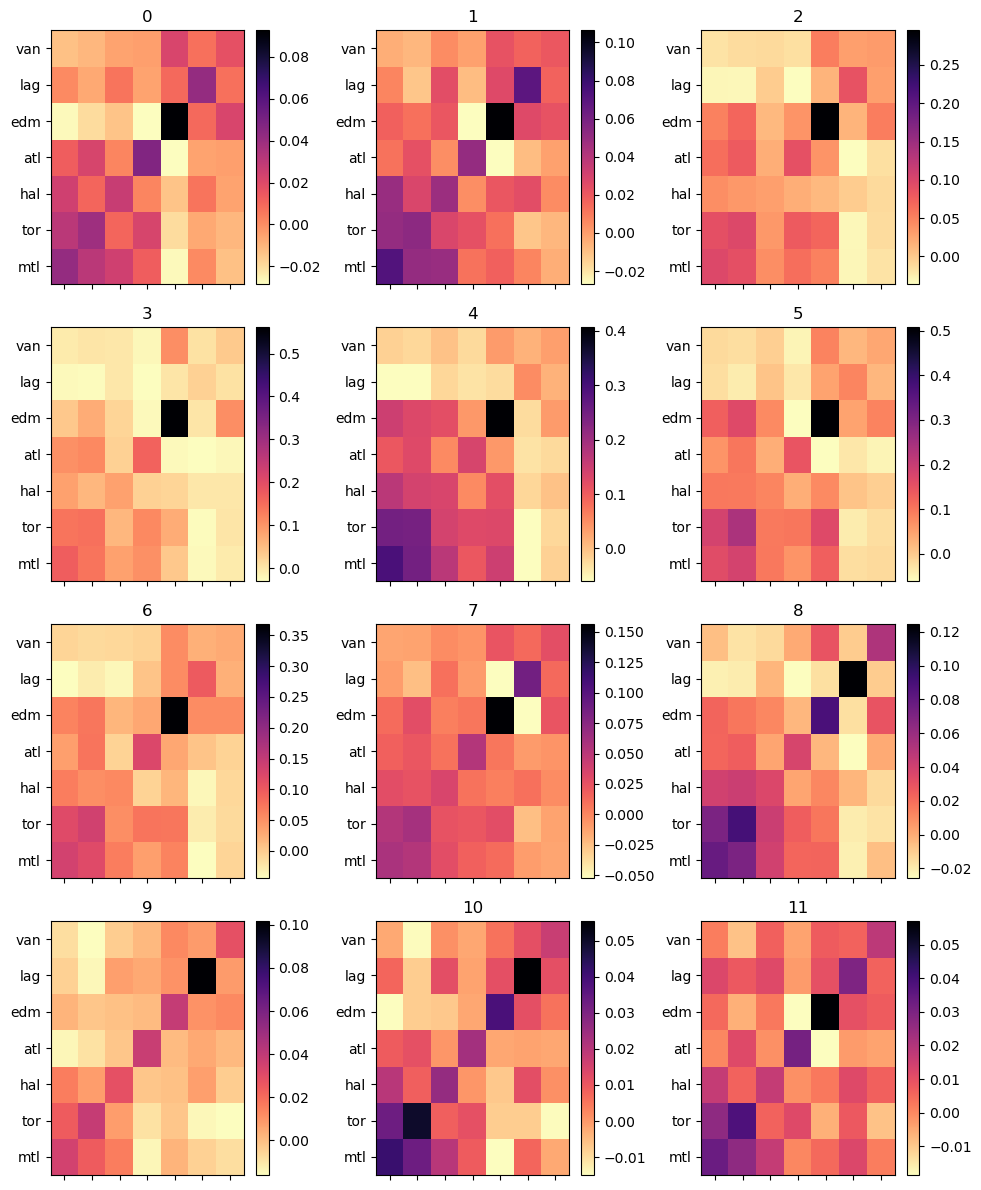

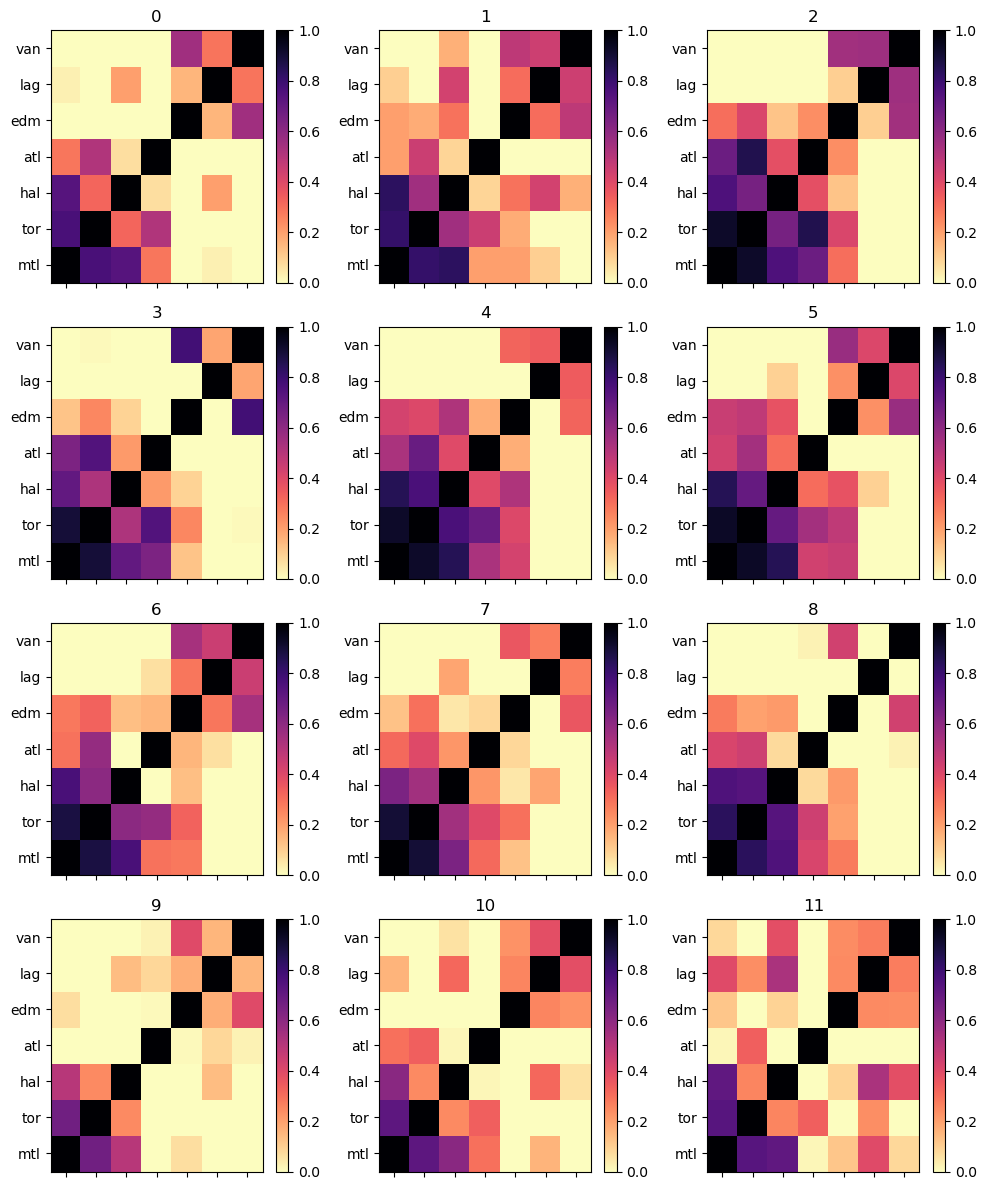

In [6]:
fig,axes=plt.subplots(4,3,figsize=(10,12))
for i in range(0,12):
    i0=i//3; i1=i%3
    c=axes[i0,i1].pcolor(cities,cities,cov_mon[:,:,i],
    cmap=plt.cm.magma_r)
    plt.colorbar(c)
    axes[i0,i1].set_title(i)
    axes[i0,i1].set_xticklabels([])
fig.tight_layout()
fig.show()

fig,axes=plt.subplots(4,3,figsize=(10,12))
for i in range(0,12):
    i0=i//3; i1=i%3
    c=axes[i0,i1].pcolor(cities,cities,cor_mon[:,:,i],
    vmin=0,vmax=1,cmap=plt.cm.magma_r)
    axes[i0,i1].set_title(i)
    plt.colorbar(c)
    axes[i0,i1].set_xticklabels([])

fig.tight_layout()
fig.show()

# Lab 1.3 

## Confidence Intervals 
1. Once again, load the temperature data in data/cities
2. calculate the p=0.1 confidence intervals and plot these around the seasonal means 
3. how do these plots relate to a hypothesis test that the seasonal means are different?

Hint: plt.fill_between is a useful function for plotting filled regions


## Some basic hypothesis testing 
1. calculate the pairwise correlation between the annual mean temperature of all the cities and plot it.
2. Add hatching to the plot to show the correlation values that are statistically significantly different from 0 at the p=0.05 level.  

Hint: plt.gca().add_patch(Rectangle((x, y), 1, 1, fill=False, hatch='l')) will plot a hatched rectangle of unit width with lower left corner at (x,y).

1.6991270265334972


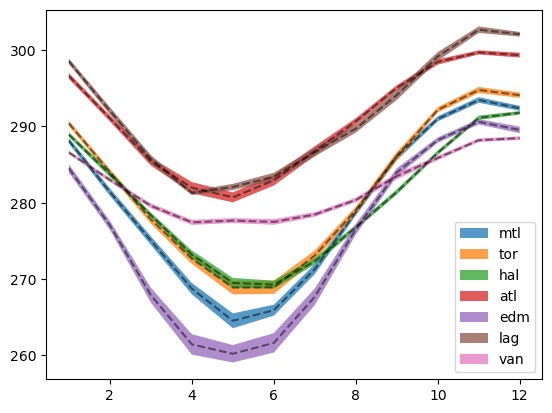

In [7]:
N=ny
tval_1=st.t.ppf(1-(0.1/2),N-1,loc=0,scale=1)
print(tval_1)
mon_mean=tdata.mean(axis=1)
mon_std=tdata.std(axis=1)
upper_bnd=mon_mean+mon_std/np.sqrt(N)*tval_1
lower_bnd=mon_mean-mon_std/np.sqrt(N)*tval_1

mon=np.arange(1,13,1)

for i in range(0,nc):
        plt.fill_between(mon,lower_bnd[i],upper_bnd[i]
        ,alpha=0.75,label=cities[i])
        plt.plot(mon,mon_mean[i],
        'k--',alpha=0.5)
plt.legend()

2.045229642132703


/tmp/ipykernel_16106/1672794666.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  tval_yr[i,j]=cor_yr[i,j]**2*np.sqrt(ny-2)/np.sqrt(1-cor_yr[i,j]**2)


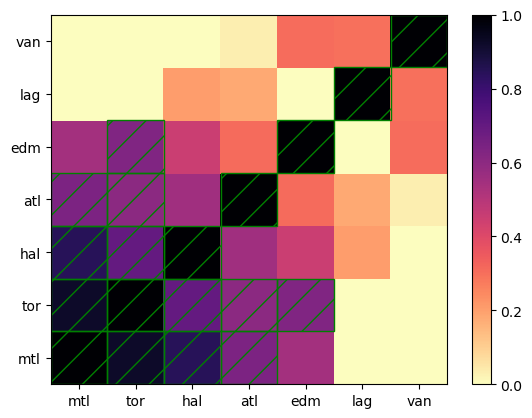

In [8]:
from matplotlib.patches import Rectangle

tdata_yr=tdata.mean(axis=-1)
cov_yr=np.zeros([nc,nc])
var_yr=np.zeros([nc])
cor_yr=np.zeros([nc,nc])
tval_yr=np.zeros([nc,nc])
for i in range(0,nc):
    cov_yr[i]=(tdata_yr*tdata_yr[i][np.newaxis]).mean(axis=-1) \
        - tdata_yr.mean(axis=-1)*tdata_yr.mean(axis=-1)[i][np.newaxis]
    var_yr[i]=(tdata_yr[i]*tdata_yr[i]).mean(axis=-1) \
        - tdata_yr[i].mean(axis=-1)**2
for i,j in product(range(0,nc),range(0,nc)):
    cor_yr[i,j]=cov_yr[i,j]/np.sqrt(var_yr[i]*var_yr[j])
    tval_yr[i,j]=cor_yr[i,j]**2*np.sqrt(ny-2)/np.sqrt(1-cor_yr[i,j]**2)

tval_05=st.t.ppf(1-(0.05/2),N-1,loc=0,scale=1)
print(tval_05)

plt.pcolor(cities,cities,cor_yr,
    vmin=0,vmax=1,cmap=plt.cm.magma_r)
h='/'
for i,j in product(range(0,nc),range(0,nc)):
    if tval_05<tval_yr[i,j]:
        plt.gca().add_patch(Rectangle((i-0.5, j-0.5), 1, 1, fill=False, hatch=h,color='g'))

plt.colorbar()
plt.show()

# Lab 1.4

A very simple model for globally averaged temperature change is 

$$ C \frac{dT}{dt} = \lambda {T} + \mathrm{ERF}  $$

the left hand side is the rate of change of energy storage in the climate system, the first term on the right hand side is the feedback term, and the second term on the right hand side is the "effective radiative forcing", which is the rate of energy storage caused by either greenhouse gases or volcanic emissions changing the radiative balance at the surface. You don't really have to know this model in any detail, but its useful to understand what the ERF is. 

The file AR6_ERF_1750-2019.csv contains the ERF time series for different forcing agents from the IPCC AR6 report estimates. These are our best understanding of the radiative impacts of different gases and aerosols.

The file 1850-2022.csv contains a global surface temperature anomalies relative to a 1971–2000 base period from the NOAAGlobalTemp dataset.

1. load the  file data/global/AR6_ERF_1850-2022.csv and plot the global temperature anomalies
2. perform a linear regression for the global temperature against time. 
   - Calculate the confidence intervals for your regression coefficients. Is the trend statistically significant at the p=0.05 level?
   - Is there anything you could do to improve the statistical significance of the trend? Should you do it if there is?  
3. load the file data/global/AR6_ERF_1750-2019.csv and plot the total_natural and total_anthropogenic ERF time series from 1850-2019.
4. Use the total_natural and total_anthropogenic ERF time series as predictors and redo the regression. Plot both the regression estimates and actual data as functions of time. What do you notice about this solution compared to the previous one?
   - calculate the confidence intervals for the regression parameters. Are they significant?
5. Redo the previous calculation but using either the total_natural xor the total_anthropogenic ERF time series. 
   - calculate the confidence intervals for the regression parameters. Are they significant? What can you conclude about global warming?

Hint: Remember to append a row of ones to your matrix in order to ensure that you are including a constant term in your regression.

Hint: you can reduce the amount of code you need to write with a function that takes in the predictors and then calculates all the outputs you need in order to completely answer each question.

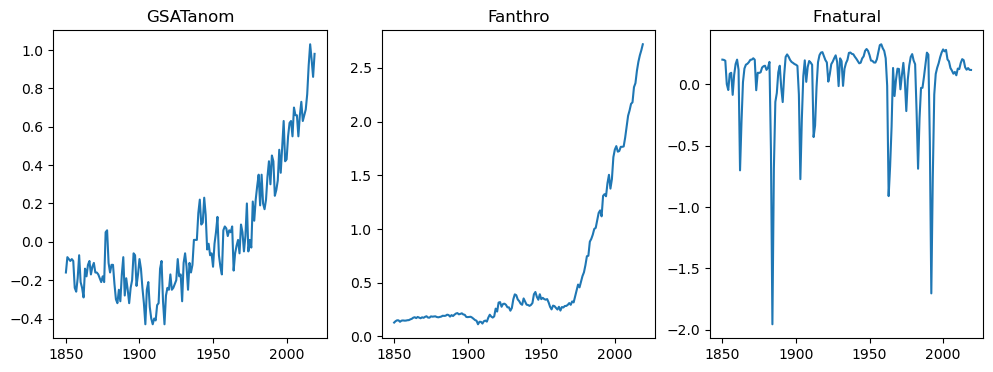

In [9]:
dsf=pd.read_csv('~/code/Upload_StatsCourse/data/global/AR6_ERF_1750-2019.csv')
dsf=dsf.where(dsf.year>=1850).dropna()
dst=pd.read_csv('~/code/Upload_StatsCourse/data/global/1850-2022.csv')
dst=dst.where(dst.Year<=2019).dropna()

T=dst.Anomaly.values
t=dst.Year.values
anthro=dsf.total_anthropogenic.values
natural=dsf.total_natural.values

fig,axs=plt.subplots(1,3,figsize=(12,4),dpi=100)
for (i,d),title in zip(enumerate([T,anthro,natural]),['GSATanom','Fanthro','Fnatural']):
    axs[i].plot(t,d)
    axs[i].set_title(title)

In [10]:
# calculate LS params and all the factors that we need for CI 
def doLS(y,X):

    print(X.shape)
    print(y.shape)

    CXXi=la.inv(np.dot(np.transpose(X),X))
    CXY =np.dot(np.transpose(X),y)
    CYX =np.dot(np.transpose(y),X)
    CYY =np.dot(np.transpose(y),y)
    A = np.dot( CXXi, CXY)
    R2 = np.dot(CYX,np.dot(CXXi,CXY))/CYY

    r=y-np.dot(A,X.T)
    S2r=np.dot(np.transpose(r),r)/(len(T)-len(A))
    CovA = S2r*CXXi

    return A, CovA, R2, S2r

(170, 2)
(170,)
0.6413323135469571 0.03855293342562811
0 0.0046747810801335095 0.005280597944565155 0.0058864148089968005
1 -11.356470006059366 -10.184140253173052 -9.011810500286737


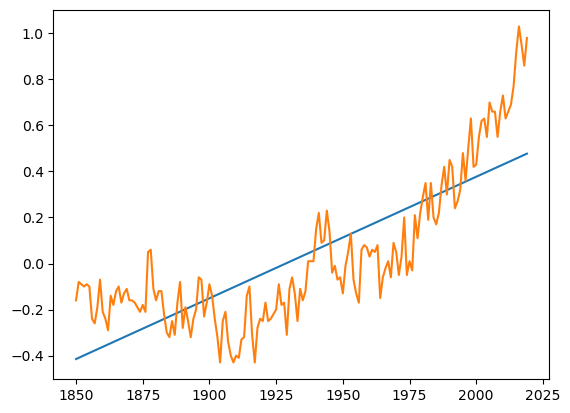

In [11]:
X=np.vstack([t,np.ones(len(t))]).T

A,CovA,R2,S2r=doLS(T,X)

print(R2,S2r)

tval=st.t.ppf(0.975,len(T)-len(A))

for i in range(0,len(A)):
    print(i,A[i]-tval*np.sqrt(CovA[i,i]),A[i],A[i]+tval*np.sqrt(CovA[i,i]))

plt.plot(t,np.dot(A,X.T))
plt.plot(t,T)

(70, 2)
(70,)
0.9353153116124676 0.005229449033747005
0 0.013571728603213049 0.014416236549723327 0.015260744496233604
1 -29.9741771734699 -28.298164290069074 -26.622151406668248


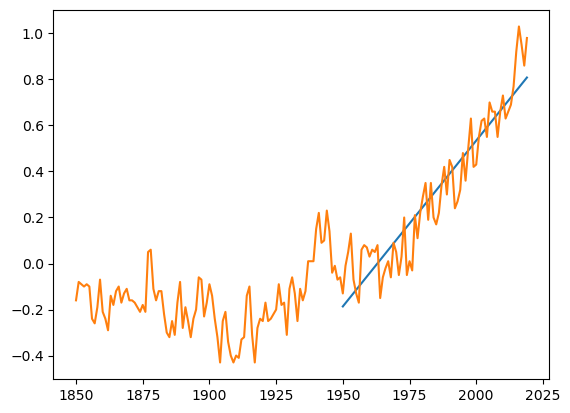

In [12]:
i0=100
X=np.vstack([t[i0:],np.ones(len(t[i0:]))]).T

A,CovA,R2,S2r=doLS(T[i0:],X)

print(R2,S2r)

tval=st.t.ppf(0.975,len(T)-len(A))

for i in range(0,len(A)):
    print(i,A[i]-tval*np.sqrt(CovA[i,i]),A[i],A[i]+tval*np.sqrt(CovA[i,i]))

plt.plot(t[i0:],np.dot(A,X.T))
plt.plot(t,T)

(170, 3)
(170,)
0.8643294893064468 0.014670450396444988
0 0.4293974814531568 0.4574224467338445 0.48544741201453223
1 0.019776990596418707 0.07958295774084397 0.13938892488526922
2 -0.2587839961334368 -0.2342901166561642 -0.20979623717889162


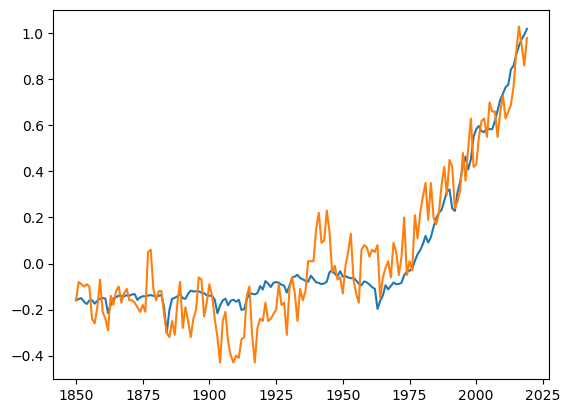

In [13]:
X=np.vstack([anthro,natural,np.ones(len(t))]).T

A,CovA,R2,S2r=doLS(T,X)

print(R2,S2r)

tval=st.t.ppf(0.975,len(T)-len(A))

for i in range(0,len(A)):
    print(i,A[i]-tval*np.sqrt(CovA[i,i]),A[i],A[i]+tval*np.sqrt(CovA[i,i]))

plt.plot(t,np.dot(A,X.T))
plt.plot(t,T)

(170, 2)
(170,)
0.020747534908273104 0.10525914800666322
0 -0.04570576004483169 0.11438184730601363 0.27446945465685896
1 -0.025523305555935294 0.024485330336241097 0.07449396622841749


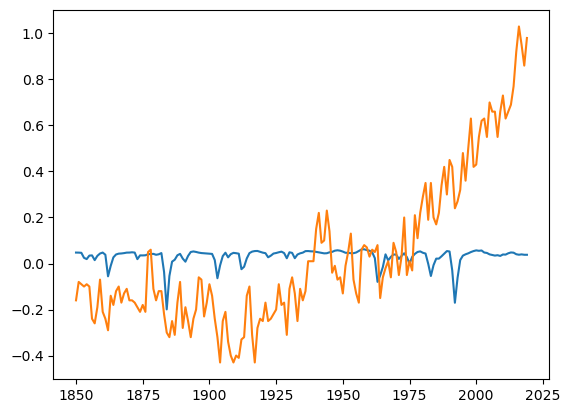

In [14]:
X=np.vstack([natural,np.ones(len(t))]).T

A,CovA,R2,S2r=doLS(T,X)

print(R2,S2r)

tval=st.t.ppf(0.975,len(T)-len(A))

for i in range(0,len(A)):
    print(i,A[i]-tval*np.sqrt(CovA[i,i]),A[i],A[i]+tval*np.sqrt(CovA[i,i]))

plt.plot(t,np.dot(A,X.T))
plt.plot(t,T)